# Coop Case Study - Viral Trending product detection

## Anomaly detection approach

## Preprocessing

In [4]:
# Libraries 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pylab
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error as mse 
from sklearn.neural_network import MLPRegressor

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (22, 14),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'axes.grid':True}

pylab.rcParams.update(params)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
name_file = '/content/drive/MyDrive/rl_4months.csv'

#### Import functions from ./Functions_Forecasting AR file in this same folder, look for comments on the functions in that notebook



In [7]:
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt 
from sklearn import *
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import scipy
from sklearn import linear_model as lm  # Used for solving linear regression problems
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cmath
import math
import datetime as dt
import matplotlib.dates as mdates
from sklearn.neural_network import MLPRegressor


def get_hourly_purchases(df_agg_hours,timestamp_agg_hours, ItemID):
    
    """
    Generates a dataframe with the chosen ItemID and its purchases every hour 
    Arguments:
        df_agg_hours: df with the aggregated purchases by timestamp (day+hour) and ItemID
        ItemID: Size of the plot, tuple
        timestamp_agg_hours: Support dictionary that has all the hours during the month to be filled
        Returns:
        Hourly Purchases of ItemID == ID in a DataFrame.
    """
    
    support = dict(zip(timestamp_agg_hours,[0]*len(timestamp_agg_hours)))
    filler = df_agg_hours[df_agg_hours['ItemID']==ItemID]
    
    
    for i in range(len(filler)):
        support[filler.iloc[i,0]] = filler.iloc[i,-1]


    df = pd.DataFrame(support.items(), columns=['timestamp', 'quantity']).set_index('timestamp')

    return df

def get_daily_purchases(df_agg_days, timestamp_agg_days, ItemID):
    
    """
    Generates a dataframe with the chosen ItemID and its purchases every hour 
    Arguments:
        df_agg_days: df with the aggregated purchases by day and ItemID
        ItemID: Size of the plot, tuple
        Returns:
        Daily Purchases of ItemID == ID in a DataFrame.
    """
    support = dict(zip(timestamp_agg_days,[0]*len(timestamp_agg_days)))
    filler = df_agg_days[df_agg_days['ItemID']==ItemID]
    
    for i in range(len(filler)):
        support[filler.iloc[i,0]] = filler.iloc[i,-1]

    df = pd.DataFrame(support.items(), columns=['DayDate', 'quantity']).set_index('DayDate')
    
    return df

def plot_trend_item(name_product, series, daily, size=(20, 8), interval = 10):
    """
    Plots the trend of an item groupped in the span of days of hours.
    Arguments:
        name_product: NameID to be shown in title
        series: DF with 2 columns: one has to be date times (%Y-%m-%d or %Y-%m-%d %H) and the other the 
            actual frequency counting of that product
        size: Size of the plot, tuple
        daily: boolean, True if the aggregation is daily based, False if hourly
        Returns:
        Plot of this Series
    """
    # Define plot space
    # define if hourly
    time_span = "Daily" if daily else "Hourly"

    plt.figure(figsize=size)    
    plt.title(time_span + " purchase trend of item = " + name_product, size=20)    
    plt.plot(series, label='sales', color="blue")   
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))


    plt.xlabel("Time (" + time_span + ")", size=20)
    plt.ylabel("Units Sales", size=20)

    # plot labels
    #ax.set(
    #xlabel = "Time (" + time_span + ")",
   # ylabel = "Units",
   # )
    
   # if daily:
   #     plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
   # else:
    #    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H'))

    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees

    plt.grid(True)




def plot_predictions_1step(y_pred, y_true, name_item, train_size, daily=1, size=(25,8), interval = 2):
    
    # define if hourly
    time_span = "Daily" if daily else "Hourly"
    
    # plot labels
    #ax.set(
    #xlabel = "Time (days)",
    #ylabel = "Units",
   # )
    
    
    
   # x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in y_true.index.values]
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    #plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees
    plt.title("1-step-ahead prediction for product = " + name_item, size=20)    
    plt.plot(y_pred, label='Sales Predicted', color="blue")   
    plt.plot(y_true, label='True Sales', color="brown")   
    
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees

    plt.xlabel("Time (" + time_span + ")", size=20)
    plt.ylabel("Units Sales", size=20)


    plt.axvline(x = train_size, color = 'red', linestyle= '--', label = 'burn-in period')
    
    #plt.plot(x,y_true.quantity.values, label = "true")

    #plt.plot(x, y_pred, label = "predictions")
    plt.grid(True)

    
    plt.legend(fontsize='xx-large')
    plt.show()

def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    p = theta.shape[1]
    
    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(m+1)
    for i in range(m):
        y_pred[i] =  (np.flip(y_target[i:i+p]) * theta).sum()
        
    return y_pred

def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = y.shape[0]
    
    # Construct the regression matrix
    Phi = np.zeros((n-p, p))
    for j in range(p):
        Phi[:,j] = y[(p-(j+1)): (n-(j+1)), 0] 
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_


def fit_nar(y, p, nhl):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = y.shape[0]
    
    # Construct the regression matrix
    Phi = np.zeros((n-p, p))# <COMPLETE THIS LINE>
    for j in range(p):
        Phi[:,j] = y[(p-(j+1)): (n-(j+1)), 0] # <COMPLETE THIS LINE>
    
    # Drop the first p values from the target vector y
    yy = y[p:].ravel()  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr =  MLPRegressor(hidden_layer_sizes = nhl, max_iter = 1000).fit(Phi, yy)    

    return regr

def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30,
            figsize=(15,5), interval=5):
    '''
    Plot ts with rolling mean and 95% confidence interval with rolling std.
    :parameter    
      :param ts: pandas Series    
      :param window: num - for rolling stats
      :param plot_ma: bool - whether plot moving average
      :param plot_intervals: bool - whether plot upper and lower bounds
    '''
    rolling_mean = ts.rolling(window=window).mean()    
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)    
    plt.title(ts.name)    
    plt.plot(ts[window:], label='Actual values', color="black")   
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))

    if plot_ma:        
        plt.plot(rolling_mean, 'g', label='MA'+str(window),
               color="red")    
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
        
    plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                    color='lightskyblue', alpha=0.4)
    
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees

    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


def find_outliers(ts, name_item=None, perc=0.01, figsize=(15,5), interval=3, plot=0):
    
    '''
    Find outliers using sklearn unsupervised support vetcor machine.
        :parameter
        :param ts: pandas Series
        :param perc: float - percentage of outliers to look for
        :return
            dtf with raw ts, outlier 1/0 (yes/no), numeric index
    '''
    
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    if plot:
        ## plot
        fig, ax = plt.subplots(figsize=figsize)
        ax.set(title="Outliers detection: found "
               +str(sum(dtf_outliers["outlier"]==1))) + ' of product = ' + name_item
        ax.plot(dtf_outliers["ts"],
                color="black")
        ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
                   y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
                   color='red')
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
        plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees

        ax.grid(True)
        plt.show()
    
    return dtf_outliers

def find_outliers_plot(dtf_outliers, name_item= None, figsize=(15,5), interval=3, filter_threshold=None):
        dtf_outliers = dtf_outliers.copy()
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(dtf_outliers["ts"],
                color="black")
        
        if filter_threshold is not None:
            thresh = dtf_outliers.ts.mean() + dtf_outliers.ts.std() * filter_threshold
            
            idx = dtf_outliers[dtf_outliers['ts'] < thresh ].index
            dtf_outliers.loc[idx, 'outlier'] = 0

        ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
                   y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
                   color='red')
        
        ax.set(title="Outliers detection: found " +str(sum(dtf_outliers["outlier"]==1))+ ' of product = ' + name_item) 

        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
        plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees

        ax.grid(True)
        plt.show()

## Creating user-defined function for arranging the results obtained from model into readable format

def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    
    return list(zip(lhs, rhs, supports, confidences, lifts))


### importing data

In [8]:
data = pd.read_csv(name_file)

In [9]:
 data.shape

(3221229, 40)

In [10]:
#data[["receiptKey","DayDate","hourOfDay","minuteOfHour","quantity","ItemID"]].iloc[0:20,]

In [11]:
# Generate unique name 
data['Unique_Item_Name'] = data['ItemCategoryName'] + '_' + data['ItemSegmentName']

In [12]:
data_subset = data[['DayDate','hourOfDay', 'ItemID', 'quantity']]



### Deletion of returns and false duplicates of Negative and 0 Quantities

In [13]:
data_subset = data_subset[data_subset.quantity>0]

In [14]:
data_subset['timestamp'] = data_subset['DayDate'].astype(str) + ' '+  data_subset['hourOfDay'].astype(str)


#### Generation of Support Timestamp Vectors

In [15]:
# Days Vector
timestamp_agg_days = data_subset['DayDate'].unique()
timestamp_agg_days.sort()


In [16]:
# Day Hour Vector
timestamp_agg_hours = [None] * len(timestamp_agg_days)*16

count = 0
for i in range(len(timestamp_agg_days)):
    
    for j in range(16):
        
        timestamp_agg_hours[count] = timestamp_agg_days[i] + ' ' + str(7 + j)
        count+=1


### Aggregating Datasets

In [17]:
# Aggregation of items with HOURLY criterion and counting ocurrences

df_agg_hours = data_subset.groupby(['timestamp', 'ItemID']).sum()
df_agg_hours.reset_index(inplace=True)
df_agg_hours.drop(columns=['hourOfDay'], inplace=True)

# Aggregation of items with DAYLY criterion and counting ocurrences

df_agg_days = data_subset.groupby(['DayDate', 'ItemID']).sum()
df_agg_days.reset_index(inplace=True)
df_agg_days.drop(columns='hourOfDay', inplace=True)

In [18]:
ItemID = 7
name_item = data[data["ItemID"]==ItemID]['Unique_Item_Name'].iloc[0]
name_item

'LÖSVIKTSGODIS_STANDARD'

In [19]:
hourly_purchase_7 = get_hourly_purchases(df_agg_hours,timestamp_agg_hours, ItemID)

In [20]:
daily_purchase_7 = get_daily_purchases(df_agg_days, timestamp_agg_days, ItemID)

In [21]:
daily_purchase_7.std() 

quantity    19.310838
dtype: float64

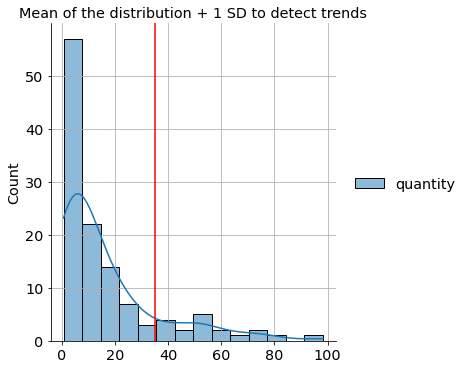

In [22]:
std_1mean = int((daily_purchase_7.mean() + daily_purchase_7.std()))
sns.displot(daily_purchase_7, kde=True).set(title='Mean of the distribution + 1 SD to detect trends')

plt.axvline(std_1mean, 0, c='r')


## Detection using Forecasting

Classify any points that lie outside the boundary as outliers

## Let's loop and retrieve all the anomalies!

Advisable to downsample dataset to most sold Items (great computational burden) 

In [23]:
unique_itemIDs = data_subset.ItemID.unique()

aggr_df = [None]*len(unique_itemIDs)
dictionary_agg_ID = dict(zip(unique_itemIDs, aggr_df))


In [24]:
df_agg_days

,DayDate,ItemID,quantity
0,2020-02-01,5,1.296
1,2020-02-01,7,56.910
2,2020-02-01,8,2.808
3,2020-02-01,22,1.000
4,2020-02-01,33,1.522
...,...,...,...
697397,2020-05-31,793899,2.000
697398,2020-05-31,794116,1.000
697399,2020-05-31,802115,1.000
697400,2020-05-31,804121,1.000


In [25]:
for i in unique_itemIDs:
    
    dictionary_agg_ID[i] = get_daily_purchases(df_agg_days, timestamp_agg_days, i)

In [26]:
unique_itemIDs[-1]

196375

In [27]:
ItemID = 7
t = dictionary_agg_ID[ItemID]
t  = t.reset_index().rename(columns={'DayDate':'ds','quantity':'y'})
t

,ds,y
0,2020-02-01,56.910
1,2020-02-02,8.854
2,2020-02-03,11.944
3,2020-02-04,16.202
4,2020-02-05,11.662
...,...,...
116,2020-05-27,8.256
117,2020-05-28,5.410
118,2020-05-29,12.018
119,2020-05-30,9.166


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [29]:

scaler = StandardScaler()
np_scaled = scaler.fit_transform(t.y.values.reshape(-1, 1))
data_sc = pd.DataFrame(np_scaled)

In [30]:
# Contamination of forest (proportion of anomalies)
outliers_fraction = float(.01)

# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data_sc) 

IsolationForest(contamination=0.01)

In [31]:
t['anomaly'] = model.predict(data_sc)
t

,ds,y,anomaly
0,2020-02-01,56.910,1
1,2020-02-02,8.854,1
2,2020-02-03,11.944,1
3,2020-02-04,16.202,1
4,2020-02-05,11.662,1
...,...,...,...
116,2020-05-27,8.256,1
117,2020-05-28,5.410,1
118,2020-05-29,12.018,1
119,2020-05-30,9.166,1


In [32]:

a = t.loc[t['anomaly'] == -1, ['y']] #anomaly
a
#t.iloc[a.index]

,y
34,79.694
68,98.204


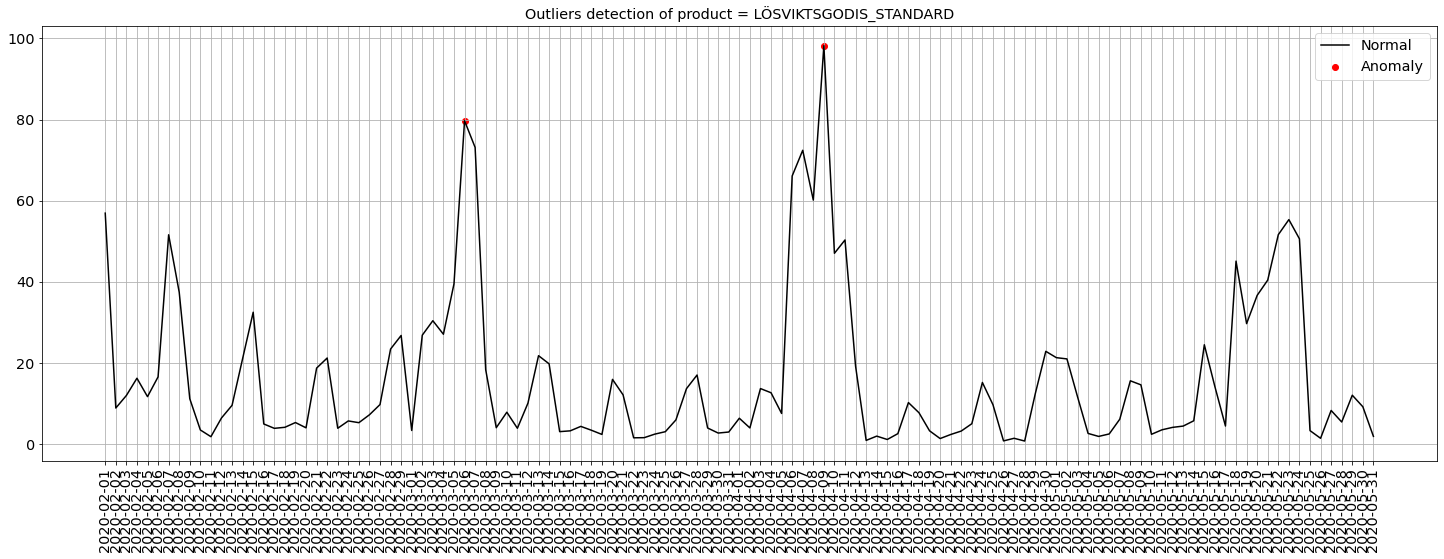

In [33]:

# visualization
fig, ax = plt.subplots(figsize=(25,8))

a = t.loc[t['anomaly'] == -1, ['ds', 'y']] #anomaly

ax.plot(t.ds, t['y'], color='black', label = 'Normal')
ax.scatter(a.ds,a['y'], color='red', label = 'Anomaly')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees

ax.set(title="Outliers detection of product = " + name_item)

plt.legend()
plt.show();


In [34]:
ItemID = 322
t = dictionary_agg_ID[ItemID]
t  = t.reset_index().rename(columns={'DayDate':'ds','quantity':'y'})
t

,ds,y
0,2020-02-01,0.0
1,2020-02-02,0.0
2,2020-02-03,0.0
3,2020-02-04,0.0
4,2020-02-05,6.0
...,...,...
116,2020-05-27,6.0
117,2020-05-28,6.0
118,2020-05-29,14.0
119,2020-05-30,0.0


In [35]:

scaler = StandardScaler()
np_scaled = scaler.fit_transform(t.y.values.reshape(-1, 1))
data_sc = pd.DataFrame(np_scaled)

In [36]:
outliers_fraction = float(.01)

# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data_sc) 

IsolationForest(contamination=0.01)

In [37]:
name_item = data[data["ItemID"]==ItemID]['Unique_Item_Name'].iloc[0]
name_item

'BUTIKSBAKATBRÖD&_WIENERBRÖD&CROISSANT'

In [38]:
t['anomaly'] = model.predict(data_sc)
t

,ds,y,anomaly
0,2020-02-01,0.0,1
1,2020-02-02,0.0,1
2,2020-02-03,0.0,1
3,2020-02-04,0.0,1
4,2020-02-05,6.0,1
...,...,...,...
116,2020-05-27,6.0,1
117,2020-05-28,6.0,1
118,2020-05-29,14.0,1
119,2020-05-30,0.0,1


In [39]:

a = t.loc[t['anomaly'] == -1, ['y']] #anomaly
a
#t.iloc[a.index]

,y
27,36.0
32,26.0


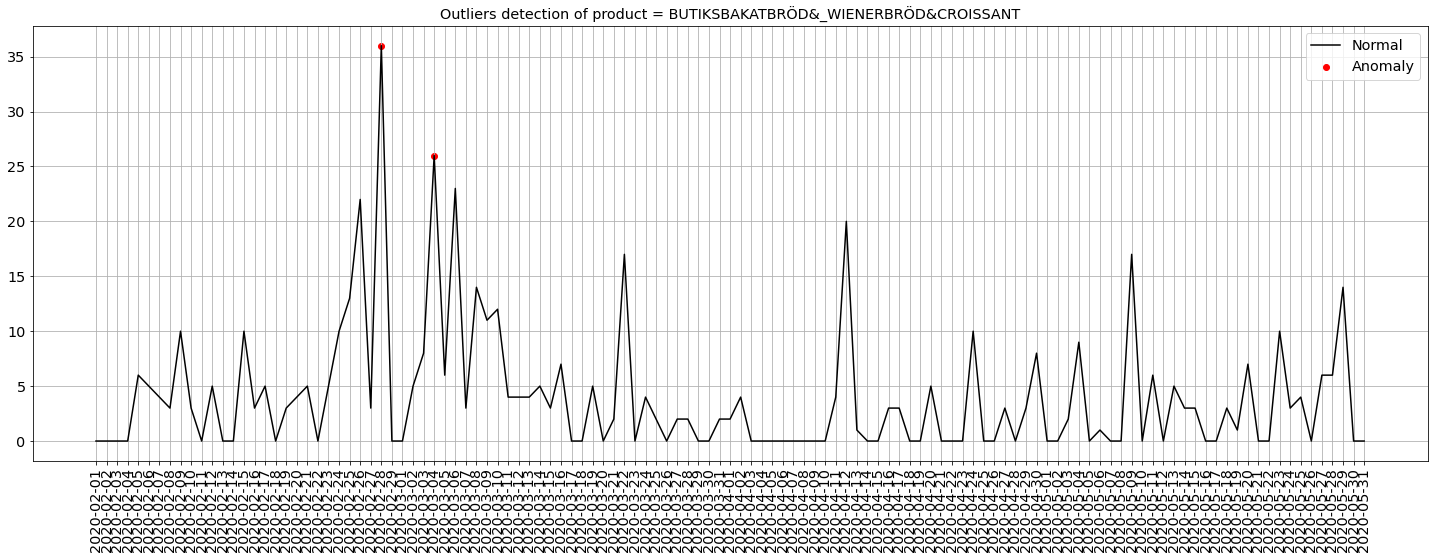

In [40]:

# visualization
fig, ax = plt.subplots(figsize=(25,8))

a = t.loc[t['anomaly'] == -1, ['ds', 'y']] #anomaly

ax.plot(t.ds, t['y'], color='black', label = 'Normal')
ax.scatter(a.ds,a['y'], color='red', label = 'Anomaly')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 90-degrees

ax.set(title="Outliers detection of product = " + name_item)

plt.legend()
plt.show();
